In [1]:
import json
import seaborn as sns
import numpy as np
import pandas as pd
#import pymc as pm
#import arviz as az
import statsmodels.api as sm
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

from IPython.display import display
from scipy import stats
from lmfit import Model, Parameters

plt.style.use("seaborn-v0_8-paper")


In [2]:
# Check current package versions after updates
import sys
print(f"Python version: {sys.version}")

try:
    import scipy
    print(f"SciPy version: {scipy.__version__}")
    
    # Check what's in scipy._lib._util
    import scipy._lib._util as util
    util_funcs = [name for name in dir(util) if not name.startswith('_')]
    print(f"Functions in scipy._lib._util: {len(util_funcs)} functions")
    if '_lazywhere' in dir(util):
        print("_lazywhere is available")
    else:
        print("_lazywhere is NOT available")
        
except ImportError as e:
    print(f"SciPy import error: {e}")

try:
    import arviz
    print(f"ArviZ version: {arviz.__version__}")
except ImportError as e:
    print(f"ArviZ import error: {e}")

try:
    import pymc
    print(f"PyMC version: {pymc.__version__}")
except ImportError as e:
    print(f"PyMC import error: {e}")
    
try:
    import statsmodels
    print(f"Statsmodels version: {statsmodels.__version__}")
except ImportError as e:
    print(f"Statsmodels import error: {e}")
    
try:
    import numpy as np
    print(f"NumPy version: {np.__version__}")
except ImportError as e:
    print(f"NumPy import error: {e}")

Python version: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:52:34) [Clang 18.1.8 ]
SciPy version: 1.16.1
Functions in scipy._lib._util: 42 functions
_lazywhere is NOT available
ArviZ import error: No module named 'arviz'
PyMC import error: No module named 'pymc'
Statsmodels version: 0.14.5
NumPy version: 1.26.4


In [3]:
nerd_sqlite = 'nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row


def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

sql = f"""
WITH group_construct AS (
    SELECT
        rg_id,
        construct_id,
        MIN(temperature) AS temperature
    FROM probe_reactions
    GROUP BY rg_id, construct_id
)
SELECT
    r.id            AS fit_run_id,
    rg.rg_label     AS reaction_group,
    gc.construct_id,
    mc.disp_name    AS construct_name,
    gc.temperature  AS temp,
    p.param_numeric AS log_kdeg
FROM probe_tc_fit_runs AS r
JOIN probe_tc_fit_params AS p
  ON p.fit_run_id = r.id
  AND p.param_name = 'log_kdeg'
JOIN group_construct AS gc
  ON gc.rg_id = r.rg_id
JOIN meta_constructs AS mc
  ON mc.id = gc.construct_id
LEFT JOIN probe_reaction_groups AS rg
  ON rg.rg_id = r.rg_id
WHERE r.fit_kind = 'round2_global'
ORDER BY r.created_at;
"""
df = read_sql(sql)
df['inv_t'] = 1.0 / (df['temp'] + 273.15)
conn.close()

In [4]:
def fit_arrhenius(df):
    # linear fit
    X = sm.add_constant(df['inv_t'] * 1000)
    model = sm.OLS(df['log_kdeg'], X)
    results = model.fit()
    print(results.summary())

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].scatter(df['inv_t'] * 1000, df['log_kdeg'], color = 'black')
    axs[0].plot(df['inv_t'] * 1000, results.predict(X), color='black')
    axs[0].set_xlabel(r'1 / T $\times 10^3$ (K$^{-1}$)')
    axs[0].set_ylabel('log($k_{deg}$) (s$^{-1}$)')

    # q-q plot
    sm.qqplot(results.resid, line ='45', ax=axs[1])
    axs[1].set_title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:               log_kdeg   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     6946.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):           2.40e-96
Time:                        07:12:22   Log-Likelihood:                -11.038
No. Observations:                 105   AIC:                             26.08
Df Residuals:                     103   BIC:                             31.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1637      0.372     67.580      0.0

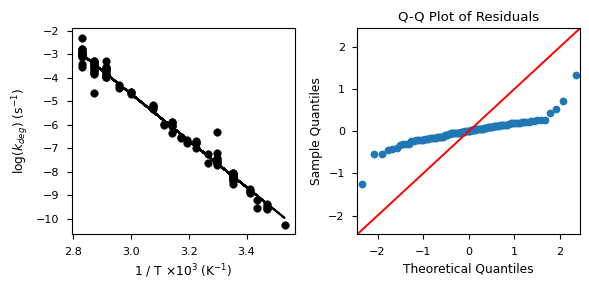

In [5]:
# fit all (hiv and 4U)
fit_arrhenius(df)

                            OLS Regression Results                            
Dep. Variable:               log_kdeg   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2337.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):           1.62e-51
Time:                        07:12:22   Log-Likelihood:                -17.769
No. Observations:                  65   AIC:                             39.54
Df Residuals:                      63   BIC:                             43.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.0388      0.654     38.276      0.0

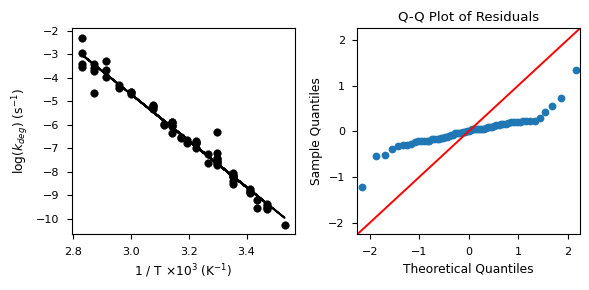

In [6]:
# filter to 4U only
df_4U = df[df['construct_name'].str.contains('4U')]
fit_arrhenius(df_4U)

                            OLS Regression Results                            
Dep. Variable:               log_kdeg   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     6663.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):           2.69e-44
Time:                        07:12:22   Log-Likelihood:                 17.000
No. Observations:                  40   AIC:                            -30.00
Df Residuals:                      38   BIC:                            -26.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1966      0.366     68.864      0.0

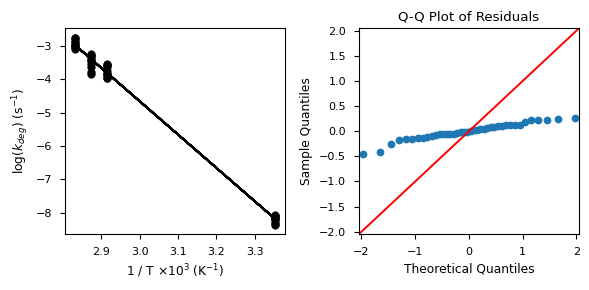

In [7]:
# filter to 4U only
df_hiv = df[df['construct_name'].str.contains('hiv_')]
fit_arrhenius(df_hiv)

In [8]:
conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

sql = """
WITH group_construct AS (
    SELECT
        rg_id,
        construct_id,
        MIN(temperature) AS temperature
    FROM probe_reactions
    GROUP BY rg_id, construct_id
)
SELECT
    r.id                   AS fit_run_id,
    r.nt_id                AS nt_id,
    mn.base                AS nt_base,
    mn.site                AS nt_site,
    rg.rg_label            AS reaction_group,
    gc.construct_id,
    mc.disp_name           AS construct_name,
    gc.temperature         AS temp,
    kobs.param_numeric     AS log_kobs,
    kobs_err.param_numeric AS log_kobs_err,
    kdeg.param_numeric     AS log_kdeg,
    meta.param_text        AS metadata_json
FROM probe_tc_fit_runs AS r
JOIN probe_tc_fit_params AS kobs
  ON kobs.fit_run_id = r.id
  AND kobs.param_name = 'log_kobs'
LEFT JOIN probe_tc_fit_params AS kdeg
  ON kdeg.fit_run_id = r.id
  AND kdeg.param_name = 'log_kdeg'
LEFT JOIN probe_tc_fit_params AS kobs_err
  ON kobs_err.fit_run_id = r.id
  AND kobs_err.param_name = 'log_kobs_err'
JOIN group_construct AS gc
  ON gc.rg_id = r.rg_id
JOIN meta_constructs AS mc
  ON mc.id = gc.construct_id
LEFT JOIN probe_reaction_groups AS rg
  ON rg.rg_id = r.rg_id
LEFT JOIN meta_nucleotides AS mn
  ON mn.id = r.nt_id
LEFT JOIN probe_tc_fit_params AS meta
  ON meta.fit_run_id = r.id
  AND meta.param_name = 'metadata'
  AND (
        meta.param_text LIKE '%"valtype": "modrate"%'
     OR meta.param_text LIKE '%"valtype": "GAmodrate"%'
      )
WHERE r.fit_kind = 'round3_constrained'
ORDER BY r.created_at;
"""

df = read_sql(sql)
metadata = df.pop('metadata_json').apply(lambda x: json.loads(x) if x else {})
df['base'] = metadata.apply(lambda d: d.get('base'))
df['site'] = metadata.apply(lambda d: d.get('site'))
df['valtype'] = metadata.apply(lambda d: d.get('valtype'))
df['inv_t'] = 1.0 / (df['temp'] + 273.15)
df['log_kobs2'] = df['log_kobs'] + df['log_kdeg']
df['endpt'] = 1 - np.exp(-df['log_kobs2'])
conn.close()

#df_filt = df[(df['base'].isin(['G'])) & (df['valtype'].isin(['GAmodrate'])) & (df['construct_name'].isin(['hiv_wt', 'hiv_gs', 'hiv_a35g', 'hiv_c30u', 'hiv_es2']))]
df_filt = df[(df['base'].isin(['A'])) & (df['valtype'].isin(['modrate'])) & (df['construct_name'].isin(['4U_wt', '4U_a8c']))]
df_filt = df_filt[df_filt['log_kobs'] > -9]
df_unmelt = df_filt[df_filt['temp'] < 60]
df_filt = df_filt[df_filt['temp'] > 60]

In [9]:
# linear function
def arrhenius_linear(inv_t, m, b):
    return m * inv_t + b

model = Model(arrhenius_linear)

# params
params = Parameters()
params.add('m', value=-5000)  # starting guess
params.add('b', value=5)

# build arrays
x = df_filt['inv_t'].to_numpy()
y = df_filt['log_kobs2'].to_numpy()

# use your per-point 1-sigma (same units as y)
sigma = df_filt['log_kobs_err'].to_numpy()

# safety: drop/clip invalid sigmas
mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
x, y, sigma = x[mask], y[mask], sigma[mask]

# weights = 1/sigma for WLS
weights = 1.0 / sigma

# weighted fit
result = model.fit(
    y, params, inv_t=x,
    weights=weights,
    nan_policy='omit',
    scale_covar=False,   # treat provided sigmas as absolute (no rescaling)
)
# eval at 25C
x25 = 1 / (25 + 273.15)
y25 = result.eval(inv_t=x25)
y25_err = result.eval_uncertainty(inv_t=x25)
y25, y25_err

(-10.925018973002715, 0.032852106774608814)

In [10]:
result

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_44373/750455316.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_filt, x='inv_t', y='log_kobs2', palette='tab10', ax=axs[0])
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_44373/750455316.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_unmelt, x='inv_t', y='log_kobs2', palette='tab10', ax=axs[1])


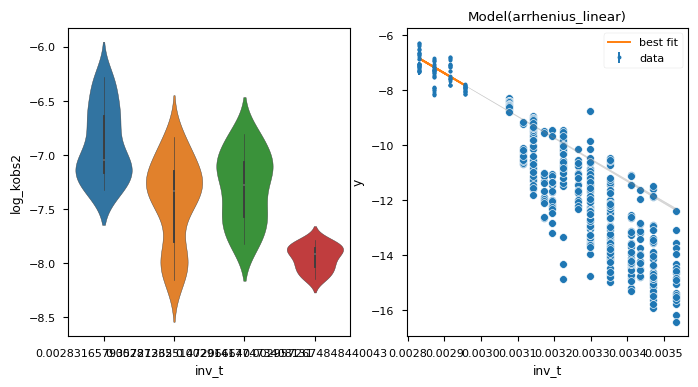

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.violinplot(data=df_filt, x='inv_t', y='log_kobs2', palette='tab10', ax=axs[0])

# plot fit and scatter
sns.scatterplot(data=df_unmelt, x='inv_t', y='log_kobs2', palette='tab10', ax=axs[1])
result.plot_fit(ax=axs[1], datafmt='.')

# evaluate fit from 25-80C
x_fit = np.linspace(1/(80+273.15), 1/(10+273.15), 100)
y_fit = result.eval(inv_t=x_fit)
y_fit_err = result.eval_uncertainty(inv_t=x_fit)

axs[1].fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err, color='gray', alpha=0.3)
plt.show()

In [12]:
# df columns expected:
#   temp (°C), log_kobs, and optionally std_err (SE of log_kobs from your nonlinear fits)
# If std_err is missing, we'll estimate it from replicate scatter within each temperature.

def prepare_df(df):
    df = df.copy()
    # convert to Kelvin and 1/T
    df["T_K"] = df["temp"] + 273.15
    df["inv_T"] = 1.0 / df["T_K"]
    # ensure we have a std_err column; if not, estimate within-temp SE
    if "std_err" not in df.columns:
        # SE of the mean per replicate measurement (here we assume each row is a replicate estimate);
        # better: use your nonlinear-fit SE if available.
        est = (
            df.groupby("temp", as_index=False)["log_kobs"]
              .agg(s=np.std, n="count")
        )
        est["std_err"] = est["s"] / np.sqrt(est["n"]).replace(0, np.nan)
        df = df.merge(est[["temp", "std_err"]], on="temp", how="left")
        # fall back to a small epsilon if completely missing to avoid zero weights
        df["std_err"] = df["std_err"].fillna(df["std_err"].median()).fillna(0.1)
    return df

def summarize_prediction(ln_mean, ln_sd):
    # back-transform to kobs
    k_mean = np.exp(ln_mean)
    # lognormal 95% CI from normal in ln-space
    lo = np.exp(ln_mean - 1.96*ln_sd)
    hi = np.exp(ln_mean + 1.96*ln_sd)
    return {"ln_kobs_298": ln_mean, "ln_se_298": ln_sd,
            "kobs_298": k_mean, "kobs_95CI": (lo, hi)}

In [13]:
def fit_pymc_hierarchical(df, add_random_intercept=False, draws=4000, chains=4, target_temp_K=298.15, random_seed=42):
    data = prepare_df(df)
    x = data["inv_T"].to_numpy()
    y = data["log_kobs"].to_numpy()
    se = data["std_err"].to_numpy()
    t_levels, t_idx = np.unique(data["temp"].to_numpy(), return_inverse=True)  # for random effects

    with pm.Model() as model:
        # Priors
        alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)  # intercept in ln-space
        beta  = pm.Normal("beta",  mu=0.0, sigma=1e3)   # very weak prior on slope

        mu = alpha + beta * x

        if add_random_intercept:
            # random intercept by temperature
            sigma_u = pm.HalfNormal("sigma_u", sigma=1.0)
            u = pm.Normal("u", mu=0.0, sigma=sigma_u, shape=len(t_levels))
            mu = mu + u[t_idx]

        # Observation model with known measurement error
        y_obs = pm.Normal("y_obs", mu=mu, sigma=se, observed=y)

        # Posterior
        idata = pm.sample(draws=draws, chains=chains, random_seed=random_seed, target_accept=0.9, progressbar=False)

        # Predict at 298 K
        x_star = 1.0 / target_temp_K
        post = idata.posterior
        alpha_s = post["alpha"].stack(s=("chain","draw")).values
        beta_s  = post["beta"].stack(s=("chain","draw")).values

        if add_random_intercept:
            # When predicting a *new* temperature, random intercept mean is zero
            # If you want the *population* prediction at an existing temperature level, add u for that level.
            ln_pred = alpha_s + beta_s * x_star
        else:
            ln_pred = alpha_s + beta_s * x_star

        ln_mean = float(np.mean(ln_pred))
        ln_sd   = float(np.std(ln_pred, ddof=1))

        return idata, summarize_prediction(ln_mean, ln_sd)

In [14]:
def fit_wls_all_points(df, target_temp_K=298.15):
    data = prepare_df(df)
    X = sm.add_constant(data["inv_T"].to_numpy())  # [1, inv_T]
    y = data["log_kobs2"].to_numpy()
    plt.plot(X, y)
    w = 1.0 / np.square(data["std_err"].to_numpy())

    model = sm.WLS(y, X, weights=w)
    res = model.fit()

    x_star = np.array([1.0, 1.0/target_temp_K])
    ln_mean = float(x_star @ res.params)

    # Var(pred) = x' Cov(b_hat) x
    cov = res.cov_params()
    ln_var = float(x_star @ cov @ x_star)
    ln_sd  = np.sqrt(ln_var)

    return res, summarize_prediction(ln_mean, ln_sd)

In [15]:
def fit_aggregate_then_wls(df, target_temp_K=298.15):
    data = prepare_df(df)

    # inverse-variance weighted mean per temp
    g = data.groupby(["temp","T_K","inv_T"], as_index=False).apply(
        lambda d: pd.Series({
            "ln_mean": np.average(d["log_kobs"], weights=1/np.square(d["std_err"])),
            # SEM of the weighted mean under known-variance model
            "ln_sem":  np.sqrt(1.0 / np.sum(1/np.square(d["std_err"])))
        })
    ).reset_index(drop=True)

    X = sm.add_constant(g["inv_T"].to_numpy())
    y = g["ln_mean"].to_numpy()
    w = 1.0 / np.square(g["ln_sem"].to_numpy())

    res = sm.WLS(y, X, weights=w).fit()

    x_star = np.array([1.0, 1.0/target_temp_K])
    ln_mean = float(x_star @ res.params)
    ln_var  = float(x_star @ res.cov_params() @ x_star)
    ln_sd   = np.sqrt(ln_var)

    return g, res, summarize_prediction(ln_mean, ln_sd)

WLS (all points) @25C: {'ln_kobs_298': -18.8093607789887, 'ln_se_298': 0.25300870175705176, 'kobs_298': 6.779511559311473e-09, 'kobs_95CI': (4.128887509445792e-09, 1.113175810135045e-08)}
Aggregate→WLS @25C: {'ln_kobs_298': -10.647521398522155, 'ln_se_298': 0.5398960738472443, 'kobs_298': 2.375965940159801e-05, 'kobs_95CI': (8.246532877174227e-06, 6.845560713672733e-05)}


/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_44373/725027141.py:16: FutureWarning: The provided callable <function std at 0x11363ce00> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(s=np.std, n="count")
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_44373/725027141.py:16: FutureWarning: The provided callable <function std at 0x11363ce00> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(s=np.std, n="count")
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_44373/480685603.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=Fals

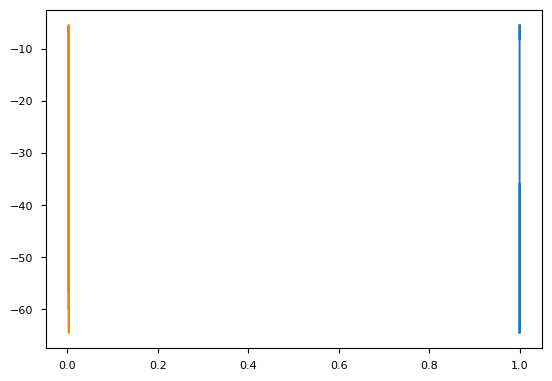

In [16]:
# Example: assume df has the columns shown in your snippet
# If you also have per-replicate SE from the time-course fits, include df["std_err"].

# (A) Bayesian, measurement-error aware (no random effects)
# idata, bayes_pred = fit_pymc_hierarchical(df, add_random_intercept=False)
# print("Bayesian (ME-aware) @25C:", bayes_pred)

# (A′) Bayesian with random intercept by temperature (optional)
# idata_re, bayes_re_pred = fit_pymc_hierarchical(df, add_random_intercept=True)
# print("Bayesian (ME-aware + per-T RE) @25C:", bayes_re_pred)

# (B) Weighted regression on all points
res_wls, wls_pred = fit_wls_all_points(df)
print("WLS (all points) @25C:", wls_pred)

# (C) Aggregate then regress
g_tbl, res_agg, agg_pred = fit_aggregate_then_wls(df)
print("Aggregate→WLS @25C:", agg_pred)

### Analysis of fmod0

In [17]:
nerd_sqlite = 'nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row


def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

construct_id = 4
sql = """
WITH group_construct AS (
    SELECT
        rg_id,
        construct_id,
        MIN(temperature) AS temperature
    FROM probe_reactions
    GROUP BY rg_id, construct_id
)
SELECT
    r.id                 AS fit_run_id,
    rg.rg_label          AS reaction_group,
    gc.construct_id,
    mc.disp_name         AS construct_name,
    gc.temperature       AS temp,
    fmod0.param_numeric  AS log_fmod0,
    kdeg.param_numeric   AS log_kdeg,
    diag_r2.param_numeric AS r2,
    meta.param_text      AS metadata_json
FROM probe_tc_fit_runs AS r
JOIN probe_tc_fit_params AS fmod0
  ON fmod0.fit_run_id = r.id
 AND fmod0.param_name = 'log_fmod0'
LEFT JOIN probe_tc_fit_params AS kdeg
  ON kdeg.fit_run_id = r.id
 AND kdeg.param_name = 'log_kdeg'
LEFT JOIN probe_tc_fit_params AS diag_r2
  ON diag_r2.fit_run_id = r.id
 AND diag_r2.param_name = 'diag:r2'
JOIN group_construct AS gc
  ON gc.rg_id = r.rg_id
JOIN meta_constructs AS mc
  ON mc.id = gc.construct_id
LEFT JOIN probe_reaction_groups AS rg
  ON rg.rg_id = r.rg_id
LEFT JOIN probe_tc_fit_params AS meta
  ON meta.fit_run_id = r.id
 AND meta.param_name = 'metadata'
WHERE r.fit_kind = 'round3_constrained'
  AND (
        meta.param_text LIKE '%"valtype": "modrate"%'
     OR meta.param_text LIKE '%"valtype": "GAmodrate"%'
      )
ORDER BY r.created_at;
"""

df_fmod0 = read_sql(sql)
conn.close()

metadata = df_fmod0.pop('metadata_json').apply(lambda x: json.loads(x) if x else {})
df_fmod0['base'] = metadata.apply(lambda d: d.get('base'))
df_fmod0['site'] = metadata.apply(lambda d: d.get('site'))
df_fmod0['valtype'] = metadata.apply(lambda d: d.get('valtype'))
df_fmod0

,fit_run_id,reaction_group,construct_id,construct_name,temp,log_fmod0,log_kdeg,r2,base,site,valtype
0,1865,80_2,6,4U_wt,80.0,-7.333277,-4.606971,-2.300249e-11,U,5,modrate
1,1866,80_2,6,4U_wt,80.0,-7.181441,-4.606971,-1.667555e-13,G,6,modrate
2,1867,80_2,6,4U_wt,80.0,-7.843884,-4.606971,-3.481881e-12,A,7,modrate
3,1868,80_2,6,4U_wt,80.0,-7.166896,-4.606971,0.000000e+00,A,8,modrate
4,1869,80_2,6,4U_wt,80.0,-6.809074,-4.606971,-5.626868e-10,C,9,modrate
...,...,...,...,...,...,...,...,...,...,...,...
4321,263509,80_2_15,5,hiv_wt,80.0,-6.475381,-3.040891,5.892971e-01,G,32,GAmodrate
4322,263510,80_2_15,5,hiv_wt,80.0,-6.392474,-3.040891,6.096365e-01,G,33,GAmodrate
4323,263511,80_2_15,5,hiv_wt,80.0,-6.212360,-3.040891,8.017136e-01,G,34,GAmodrate
4324,263513,80_2_15,5,hiv_wt,80.0,-6.301935,-3.040891,7.132232e-01,G,36,GAmodrate


In [18]:
def calc_logit(f):
    # Logit-normal fit for comparison (if f in (0,1))
    logit_f = np.log(f / (1 - f))
    mu, sigma = stats.norm.fit(logit_f)
    print(f"Logit-normal μ={mu:.3f}, σ={sigma:.3f}")

    return logit_f, mu, sigma

In [19]:
def plot_fmod0_r2_logitfit(df_wt, mu, sigma, logit_f):

    fig = plt.figure(figsize=(8, 3))
    gs = GridSpec(
        1, 3, width_ratios=[4, 1, 4], wspace=0.2,
        figure=fig
    )

    # Scatter plot
    ax_scatter = fig.add_subplot(gs[0, 0])
    ax_scatter.scatter(df_wt['r2'], df_wt['fmod0'], alpha=0.6)
    ax_scatter.set_xlabel('r2')
    ax_scatter.set_ylabel('fmod0')

    # Histogram aligned with the y-axis
    ax_hist = fig.add_subplot(gs[0, 1], sharey=ax_scatter)
    ax_hist.hist(
        df_wt['fmod0'],
        bins=30,
        orientation='horizontal',
        color='grey',
        alpha=0.7
    )
    ax_hist.set_xlabel('count')
    plt.setp(ax_hist.get_yticklabels(), visible=False)

    # logit-normal fit
    ax_logitfit = fig.add_subplot(gs[0, 2])
    x_logit = np.linspace(logit_f.min(), logit_f.max(), 200)
    ax_logitfit.hist(logit_f, bins=30, density=True, alpha=0.5, label='Observed (logit)')
    ax_logitfit.plot(x_logit, stats.norm.pdf(x_logit, mu, sigma), 'r-', label=f'Logit-normal fit u={mu:.2f}, s={sigma:.2f}')
    ax_logitfit.legend()
    plt.tight_layout()
    plt.show()


Logit-normal μ=-6.337, σ=0.261


/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_44373/4124484728.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


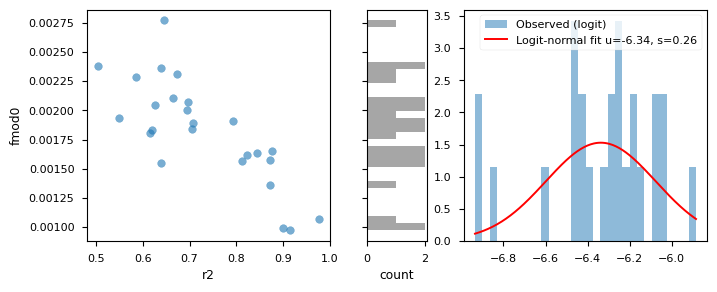

In [20]:
df_wt = df_fmod0[df_fmod0['construct_name'].str.contains('hiv_')]
df_wt = df_wt[df_wt['r2'] > 0.5]
df_wt = df_wt[df_wt['site'] == 40]
df_wt = df_wt[df_wt['base'] == 'U']
df_wt['fmod0'] = np.exp(df_wt['log_fmod0'])
# Extract variable
f = df_wt['fmod0'].to_numpy()
logit_f, mu, sigma = calc_logit(f)
plot_fmod0_r2_logitfit(df_wt, mu, sigma, logit_f)

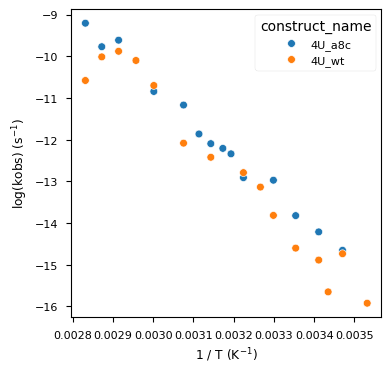

In [21]:
df_site = df[df['site'].isin([5, 10, 11, 12, 13, 17, 20, 23, 24, 32, 33])] # U sites
df_site = df[df['site'].isin([6, 14, 19, 21, 27, 28, 30, 31])]             # G sites
#df_site = df[df['site'].isin([7,15, 16, 18, 22, 26, 29])]
df_site = df[df['base'].isin(['G'])] # A sites

df_site = df_site[df_site['valtype'] == 'GAmodrate']
df_site = df_site[df_site['construct_name'].isin(['4U_wt', '4U_a8c'])]
df_site = df_site[df_site['log_kobs2'] > -20]

# group by site and get mean
df_site_grouped = df_site.groupby(['construct_name', 'inv_t']).agg({
    'log_kobs2': 'mean',
    'temp': 'mean'
}).reset_index()

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=df_site_grouped, x='inv_t', y='log_kobs2', hue='construct_name', palette = 'tab10', ax=ax)
ax.set_xlabel(r'1 / T (K$^{-1}$)')
ax.set_ylabel('log(kobs) (s$^{-1}$)')
plt.show()

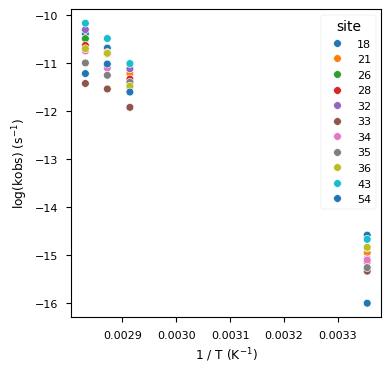

In [22]:
df_site = df[df['site'].isin([20, 22, 27])] # A sites
#df_site = df[df['site'].isin([21, 26, 28, 32, 33, 34, 36, 43])]  # G sites
df_site = df[df['site'].isin([21, 26, 28, 32, 33, 34, 36, 43])]  # G sites
#df_site = df[df['site'].isin([7,15, 16, 18, 22, 26, 29])]
df_site = df[df['base'].isin(['G'])] # A sites

df_site = df_site[df_site['valtype'] == 'modrate']
df_site = df_site[df_site['construct_name'].isin(['hiv_wt', 'hiv_gs', 'hiv_a35g', 'hiv_c30u', 'hiv_es2'])]
df_site = df_site[df_site['log_kobs2'] > -20]

# group by site and get mean
df_site_grouped = df_site.groupby(['site', 'inv_t']).agg({
    'log_kobs2': 'mean',
    'temp': 'mean'
}).reset_index()

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=df_site_grouped, x='inv_t', y='log_kobs2', hue='site', palette = 'tab10', ax=ax)
ax.set_xlabel(r'1 / T (K$^{-1}$)')
ax.set_ylabel('log(kobs) (s$^{-1}$)')
plt.show()

In [23]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path

In [24]:
def visualize_melted_fit(DB_PATH, RUN_LABEL, fit_name, df_unmelt):
    """
    Visualize a stored Arrhenius fit (and its raw points) pulled from tempgrad results.

    Parameters
    ----------
    DB_PATH : str or Path
        Path to manuscript_pipeline/NERD.sqlite (or another NERD db).
    RUN_LABEL : str
        Task run label (e.g., "05_probe_tempgrad_fit").
    fit_name : str
        The user-defined `fit_name` saved in the tempgrad config.
    df_unmelt : pandas.DataFrame
        DataFrame with columns `inv_t` and `log_kobs2` for extra overlays (optional).
    """

    fit_query = """
    SELECT
        fr.id AS fit_run_id,
        fr.target_label,
        fr.created_at,
        MAX(CASE WHEN p.param_name = 'slope' THEN p.param_numeric END) AS slope,
        MAX(CASE WHEN p.param_name = 'intercept' THEN p.param_numeric END) AS intercept,
        MAX(CASE WHEN p.param_name = 'meta:temperatures_used_c' THEN p.param_text END) AS temps_json,
        MAX(CASE WHEN p.param_name = 'meta:src_kobs_data' THEN p.param_text END) AS src_json,
        MAX(CASE WHEN p.param_name = 'meta:outliers_removed' THEN p.param_text END) AS outliers_json,
        MAX(CASE WHEN p.param_name = 'meta:fit_name' THEN p.param_text END) AS fit_name
    FROM tempgrad_fit_runs fr
    JOIN core_tasks t ON t.id = fr.task_id
    JOIN tempgrad_fit_params p ON p.fit_run_id = fr.id
    WHERE t.label = ?
      AND fr.fit_kind = 'arrhenius'
    GROUP BY fr.id, fr.target_label, fr.created_at
    HAVING MAX(CASE WHEN p.param_name = 'meta:fit_name' THEN p.param_text END) = ?
    ORDER BY fr.created_at DESC;
    """

    with sqlite3.connect(DB_PATH) as conn:
        fit_df = pd.read_sql_query(fit_query, conn, params=(RUN_LABEL, fit_name))

    if fit_df.empty:
        print(f"No Arrhenius fits found for run '{RUN_LABEL}' with fit_name '{fit_name}'.")
        return

    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(11, 4.5), constrained_layout=True, sharex=False
    )
    ax_rate, ax_ln = axes

    for _, row in fit_df.iterrows():
        try:
            temps_c = np.asarray(json.loads(row["temps_json"]), dtype=float)
            src_points = json.loads(row["src_json"])
        except (TypeError, ValueError, json.JSONDecodeError):
            continue

        if temps_c.size == 0 or not src_points:
            continue

        # Left: per-point kobs2 vs. temperature
        temps_scatter = np.array([pt["temperature_c"] for pt in src_points], dtype=float)
        rates_scatter = np.array([pt.get("kobs2") for pt in src_points], dtype=float)
        ax_rate.scatter(
            temps_scatter,
            rates_scatter,
            alpha=0.65,
            s=40,
            label=f"{row['target_label']} data",
        )

        # Weighted Arrhenius fit (line)
        
        span_c = np.linspace(df_unmelt['temp'].min(), temps_c.max(), 100)
        span_inv_t = 1.0 / (span_c + 273.15)
        ln_pred = row["slope"] * span_inv_t + row["intercept"]
        rate_pred = np.exp(ln_pred)
        ax_rate.plot(
            span_c,
            rate_pred,
            linewidth=2,
            label=f"{row['target_label']} fit",
        )

        # Right: ln(kobs2) vs 1/T (per point)
        log_rates = np.array([pt.get("log_kobs2") for pt in src_points], dtype=float)
        inv_t_points = 1.0 / (temps_scatter + 273.15)
        ax_ln.scatter(
            inv_t_points,
            log_rates,
            alpha=0.65,
        )
        ax_ln.plot(
            span_inv_t,
            row["slope"] * span_inv_t + row["intercept"],
            linewidth=2,
            label=f"{row['target_label']} fit",
        )

        # Optional overlay of any extra unmelted dataset
        if df_unmelt is not None and not df_unmelt.empty:
            sns.scatterplot(data=df_unmelt, x="inv_t", y="log_kobs2", palette="tab10", ax=ax_ln)

        # Annotate outliers removed (if any)
        outliers_json = row.get("outliers_json")
        if isinstance(outliers_json, str) and outliers_json:
            try:
                removed = json.loads(outliers_json)
            except json.JSONDecodeError:
                removed = None
            if removed:
                parts = []
                if removed.get("rg_ids"):
                    parts.append("rg_id " + ",".join(map(str, removed["rg_ids"])))
                if removed.get("nt_ids"):
                    parts.append("nt_id " + ",".join(map(str, removed["nt_ids"])))
                if removed.get("rg_nt_ids"):
                    parts.append("rg_nt_id " + ",".join(removed["rg_nt_ids"]))
                if parts:
                    annotation = "Removed: " + "; ".join(parts)
                    ax_rate.text(
                        0.02,
                        0.95,
                        annotation,
                        transform=ax_rate.transAxes,
                        fontsize=8,
                        verticalalignment="top",
                        bbox=dict(facecolor="white", alpha=0.4, edgecolor="none"),
                    )

    ax_rate.set_xlabel("Temperature (°C)")
    ax_rate.set_ylabel("kobs2 (s$^{-1}$)")
    ax_rate.set_title(f"Transformed Rates — {fit_name}")
    ax_rate.grid(True, alpha=0.2)

    ax_ln.set_xlabel("1 / Temperature (K$^{-1}$)")
    ax_ln.set_ylabel("ln(kobs2)")
    ax_ln.set_title("Arrhenius Fit (log-linear)")
    ax_ln.grid(True, alpha=0.2)

    handles, labels = ax_rate.get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=min(len(labels), 3))

    plt.show()

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_44373/3438485562.py:101: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_unmelt, x="inv_t", y="log_kobs2", palette="tab10", ax=ax_ln)


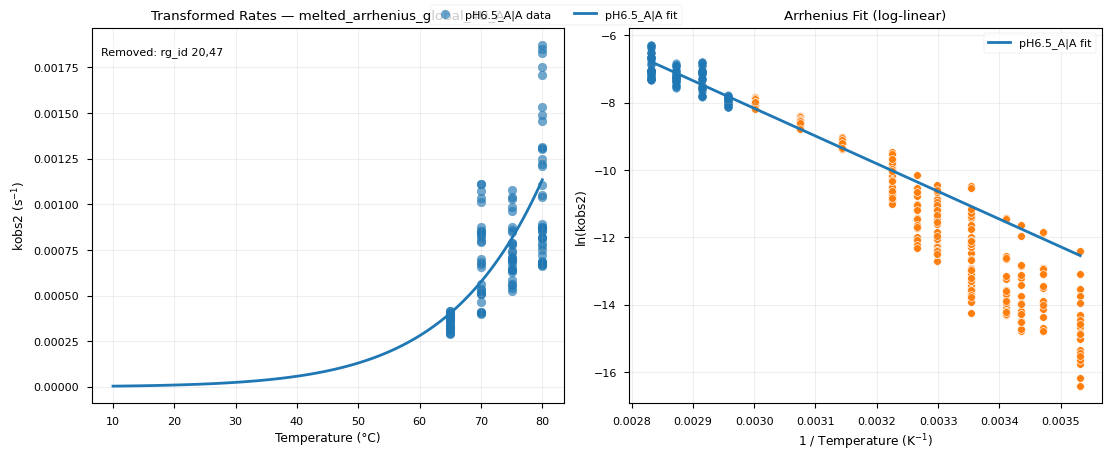

In [25]:

#df_filt = df[(df['base'].isin(['G'])) & (df['valtype'].isin(['GAmodrate'])) & (df['construct_name'].isin(['hiv_wt', 'hiv_gs', 'hiv_a35g', 'hiv_c30u', 'hiv_es2']))]
df_filt = df[(df['base'].isin(['A'])) & (df['valtype'].isin(['modrate'])) & (df['construct_name'].isin(['4U_wt']))]
df_filt = df_filt[df_filt['log_kobs'] > -9]
df_unmelt = df_filt[df_filt['temp'] < 61]

DB_PATH = Path("nerd.sqlite")
RUN_LABEL = "05_probe_tempgrad_fit"
fit_name = "melted_arrhenius_global_4U_A"  # whichever you saved in the YAML
visualize_melted_fit(DB_PATH, RUN_LABEL, fit_name, df_unmelt)

In [26]:
from lmfit import Model
from lmfit.models import LinearModel
from lmfit import Parameters, minimize

# === Tempgrad 2-state melting fit ===
def melt_fit(x, a, b, c, d, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987 # kcal/mol
    R = 0.0083145 
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1
    baseu = a * x + b
    basef = c * x + d

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None):
    
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y[:3], x = x[:3])
    top_fit = model.fit(y[:3], params, x = x[:3])
    init_m_top = top_fit.params['slope'].value
    init_b_top = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y[-3:], x = x[-3:])
    bot_fit = model.fit(y[-3:], params, x = x[-3:])
    init_m_bot = bot_fit.params['slope'].value
    init_b_bot = bot_fit.params['intercept'].value
    init_m = (init_m_top + init_m_bot) / 2

    # Actual fit
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(a = init_m_top, b = init_b_top, c = init_m_bot, d = init_b_bot, f = -500, g = 40)
    melt_params['g'].vary = True
    # bottom intercept needs to be lower than upper intercept
    melt_params['d'].max = init_b_top

    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['c'].value = kadd_slope
        melt_params['d'].value = kadd_intercept
        melt_params['c'].vary = False
        melt_params['d'].vary = False
    

    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    return melt_result

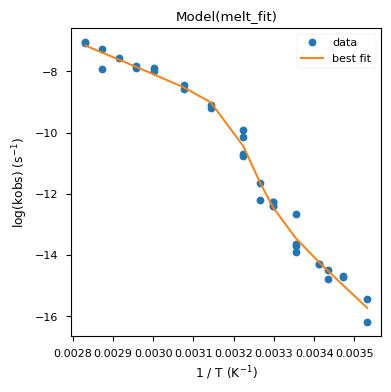

In [27]:
#df_filt = df[(df['base'].isin(['G'])) & (df['valtype'].isin(['GAmodrate'])) & (df['construct_name'].isin(['hiv_wt', 'hiv_gs', 'hiv_a35g', 'hiv_c30u', 'hiv_es2']))]
df_filt = df[(df['base'].isin(['A', 'G', 'C', 'T', 'U'])) & (df['valtype'].isin(['modrate', 'GAmodrate'])) & (df['construct_name'].isin(['4U_wt']))]
df_filt = df_filt[df_filt['log_kobs'] > -9]

df_test_meltfit = df_filt[df_filt['construct_name'] == '4U_wt']
# select site
df_test_meltfit = df_test_meltfit[df_test_meltfit['site'] == 26]
# select valtype modrate
df_test_meltfit = df_test_meltfit[df_test_meltfit['valtype'] == 'modrate']
# sort by temp
df_test_meltfit = df_test_meltfit.sort_values(by='temp', ascending=True)

fig, ax = plt.subplots(figsize=(4, 4))

try:
    # melt fit
    melt_result = fit_meltcurve(df_test_meltfit['inv_t'], df_test_meltfit['log_kobs2'])
    melt_result.plot_fit(ax=ax)

except:
    # plot without fit
    sns.scatterplot(data=df_test_meltfit, x='inv_t', y='log_kobs2', palette='tab10', ax=ax)
    
ax.set_xlabel(r'1 / T (K$^{-1}$)')
ax.set_ylabel('log(kobs) (s$^{-1}$)')
plt.show()

In [28]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Parameters, minimize
from pathlib import Path
import sqlite3

R_GAS_CONSTANT = 0.0019872041  # kcal mol^-1 K^-1
#R_GAS_CONSTANT = 0.0083145      # kJ mol^-1 K^-1

# ---------------------------------------------------------------------------
# Arrhenius-like melt model
# ---------------------------------------------------------------------------
def melt_fit(inv_t, a, b, c, d, f, g):
    """
    inv_t: 1 / T(K)
    a,b:   'upper' (high-T) linear branch coefficients: a*inv_t + b
    c,d:   'lower' (low-T) linear branch coefficients:  c*inv_t + d
    f:     energetic scale (kcal/mol); typically negative for unfolding to increase with T
    g:     melt midpoint in Celsius
    """

    temp_k = 1.0 / inv_t
    Tg = g + 273.15
    K = np.exp((f / R_GAS_CONSTANT) * (1.0 / Tg - inv_t))
    frac_unfolded = 1.0 / (1.0 + K)
    frac_folded = 1.0 - frac_unfolded
    upper = a * inv_t + b
    lower = c * inv_t + d
    return frac_unfolded * upper + frac_folded * lower

def _initial_linear_guess(inv_t, logk):
    """
    Simple linear fits to the top and bottom 3 points to seed melt fit.
    Falls back to global linear fit if <3 points are available.
    """
    inv_t = np.asarray(inv_t, float)
    logk = np.asarray(logk, float)
    sort_idx = np.argsort(inv_t)
    inv_t_sorted = inv_t[sort_idx]
    logk_sorted = logk[sort_idx]

    if len(inv_t_sorted) >= 3:
        # Top 3 points (lowest inv_t = highest T)
        x_top = inv_t_sorted[:3]
        y_top = logk_sorted[:3]
        A_top = np.vstack([x_top, np.ones_like(x_top)]).T
        slope_top, intercept_top = np.linalg.lstsq(A_top, y_top, rcond=None)[0]

        # Bottom 3 points (highest inv_t = lowest T)
        x_bot = inv_t_sorted[-3:]
        y_bot = logk_sorted[-3:]
        A_bot = np.vstack([x_bot, np.ones_like(x_bot)]).T
        slope_bot, intercept_bot = np.linalg.lstsq(A_bot, y_bot, rcond=None)[0]
    else:
        # Fallback: one global line, use it for both branches
        A = np.vstack([inv_t_sorted, np.ones_like(inv_t_sorted)]).T
        slope, intercept = np.linalg.lstsq(A, logk_sorted, rcond=None)[0]
        slope_top = slope_bot = slope
        intercept_top = intercept_bot = intercept

    return slope_top, intercept_top, slope_bot, intercept_bot

def _as_site_dict(site_data):
    """
    Normalize input to {site_id: df_site} where each df has
    columns: temp (°C), log_kobs2, (optional) log_kobs2_err
    """
    if isinstance(site_data, dict):
        return site_data
    if not isinstance(site_data, pd.DataFrame):
        raise TypeError("site_data must be dict or pandas DataFrame.")
    required = {"site", "temp", "log_kobs2"}
    if not required.issubset(set(site_data.columns)):
        raise ValueError(f"DataFrame must contain columns: {required}")
    return {sid: g.copy() for sid, g in site_data.groupby("site")}

def build_global_parameters(site_data, shared_label="global", init_ab=None):
    """
    Create lmfit.Parameters with shared upper baseline (a,b) across all sites.
    site_data: dict {site_id: df_site} or long DataFrame (cols: site, temp, log_kobs2, [log_kobs2_err])
    Optionally seed with init_ab=(a0,b0).
    """
    site_dict = _as_site_dict(site_data)

    params = Parameters()
    # Shared (global) upper-line parameters
    if init_ab is None:
        params.add(f"a_{shared_label}", value=0.0)
        params.add(f"b_{shared_label}", value=0.0)
    else:
        params.add(f"a_{shared_label}", value=float(init_ab[0]))
        params.add(f"b_{shared_label}", value=float(init_ab[1]))

    top_slopes, top_inters = [], []

    # Per-site parameters (lower line + transition energetics)
    for site_id, df_site in site_dict.items():
        inv_t = 1.0 / (df_site["temp"].to_numpy(float) + 273.15)
        logk = df_site["log_kobs2"].to_numpy(float)

        slope_top, intercept_top, slope_bottom, intercept_bottom = _initial_linear_guess(inv_t, logk)
        top_slopes.append(slope_top)
        top_inters.append(intercept_top)

        params.add(f"c_{site_id}", value=float(slope_bottom), vary=True)
        params.add(f"d_{site_id}", value=float(intercept_bottom), vary=True)
        params.add(f"f_{site_id}", value=-400.0, min=-1e5, max=0.0)   # kcal/mol scale param
        params.add(f"g_{site_id}", value=40.0, min=30.0, max=60.0)    # melt midpoint (°C)

    # If not provided, set shared a,b from medians of top-branch seeds
    if init_ab is None:
        if len(top_slopes) > 0:
            params[f"a_{shared_label}"].set(value=float(np.median(top_slopes)))
            params[f"b_{shared_label}"].set(value=float(np.median(top_inters)))
        else:
            params[f"a_{shared_label}"].set(value=0.0)
            params[f"b_{shared_label}"].set(value=0.0)

    # params[f"a_{shared_label}"].set(value=-5000)
    # params[f"b_{shared_label}"].set(value=10)

    return params

def _global_melt_residual(params, site_data, shared_label="global", weight=True):
    site_dict = _as_site_dict(site_data)
    residuals = []

    a = params[f"a_{shared_label}"].value
    b = params[f"b_{shared_label}"].value

    for site_id, df_site in site_dict.items():
        c = params[f"c_{site_id}"].value
        d = params[f"d_{site_id}"].value
        f_val = params[f"f_{site_id}"].value
        g_val = params[f"g_{site_id}"].value

        inv_t = 1.0 / (df_site["temp"].to_numpy(float) + 273.15)
        y_obs = df_site["log_kobs2"].to_numpy(float)
        sigma = df_site["log_kobs2_err"].to_numpy(float) if "log_kobs2_err" in df_site.columns else None

        y_pred = melt_fit(inv_t, a, b, c, d, f_val, g_val)

        if weight and (sigma is not None):
            valid = np.isfinite(sigma) & (sigma > 0)
            resid = np.empty_like(y_obs)
            resid[valid] = (y_obs[valid] - y_pred[valid]) / sigma[valid]
            resid[~valid] = (y_obs[~valid] - y_pred[~valid])
        else:
            resid = y_obs - y_pred

        residuals.append(resid)

    return np.concatenate(residuals)

def fit_global_melt(site_data, shared_label="global", init_ab=None, weight=True, method="least_squares"):
    """
    site_data: dict {site_id: df_site} OR long DataFrame with columns:
               site, temp, log_kobs2, (optional) log_kobs2_err
    shared_label: name suffix for shared a,b params
    """
    params = build_global_parameters(site_data, shared_label=shared_label, init_ab=init_ab)
    result = minimize(
        _global_melt_residual,
        params,
        args=(site_data, shared_label, weight),
        method=method
    )
    return result

In [29]:
def _predict_site(inv_t, params, site_id, shared_label="global"):
    """Helper: compute y_pred for a given site and inv_t array from fitted params."""
    a = params[f"a_{shared_label}"].value
    b = params[f"b_{shared_label}"].value
    c = params[f"c_{site_id}"].value
    d = params[f"d_{site_id}"].value
    f_val = params[f"f_{site_id}"].value
    g_val = params[f"g_{site_id}"].value
    return melt_fit(inv_t, a, b, c, d, f_val, g_val)

def plot_global_melt_2panel(
    result, site_data, shared_label="global", sites_to_plot=None,
    npoints=200
):
    """
    2-subplot visualization:
    Left: log(kobs2) vs temp (°C) + melt fit
    Right: log(kobs2) vs 1/T (Arrhenius) + linear asymptotes
    
    Parameters
    ----------
    result : lmfit.MinimizerResult
    site_data : df or dict of dfs
    sites_to_plot : list of site IDs or None (None = all)
    npoints : smooth curve resolution
    """
    site_dict = _as_site_dict(site_data)

    # filter sites if requested
    if sites_to_plot is None:
        sites = list(site_dict.keys())
    else:
        sites = [s for s in site_dict.keys() if s in sites_to_plot]

    colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(sites))))

    fig, ax = plt.subplots(figsize=(4, 3.5))


    for i, site in enumerate(sites):
        df = site_dict[site]
        T = df["temp"].to_numpy(float)
        y = df["log_kobs2"].to_numpy(float)
        invT = 1/(T + 273.15)

        # scatter data LEFT
        if "log_kobs2_err" in df.columns:
            yerr = df["log_kobs2_err"].to_numpy(float)
            ax.errorbar(invT, y, yerr=yerr, fmt='o', ms=4, capsize=2,
                             color=colors[i], alpha=0.85, label=f"{site} data")
        else:
            ax.plot(invT, y, 'o', ms=4, color=colors[i], alpha=0.85, label=f"{site} data")

        # smooth melt curve
        T_grid = np.linspace(T.min(), T.max(), npoints)
        invT_grid = 1/(T_grid + 273.15)
        y_fit = _predict_site(invT_grid, result.params, site, shared_label)

        ax.plot(invT_grid, y_fit, '-', lw=2, color=colors[i], label=f"{site} fit")

        # linear asymptotes (Arrhenius upper/lower)
        a = result.params[f"a_{shared_label}"].value
        b = result.params[f"b_{shared_label}"].value
        c = result.params[f"c_{site}"].value
        d = result.params[f"d_{site}"].value

        y_upper = a * invT_grid + b
        y_lower = c * invT_grid + d
        ax.plot(invT_grid, y_upper, '--', lw=1.5, color=colors[i])
        ax.plot(invT_grid, y_lower, '--', lw=1.5, color=colors[i])

    # ---- styling ----
    ax.set_xlabel("1/T (K$^{-1}$)")
    ax.set_ylabel("log(k_obs)")
    ax.set_title("Melt view")

    fig.tight_layout()
    return fig, axs

In [30]:
df_filt = df[(df['base'].isin(['A', 'G', 'C', 'T', 'U'])) & (df['valtype'].isin(['modrate', 'GAmodrate'])) & (df['construct_name'].isin(['4U_wt', '4U_a8c']))]
df_filt_A = df_filt[(df_filt['base'].isin(['A'])) & (df_filt['valtype'].isin(['modrate'])) & (df_filt['construct_name'].isin(['4U_wt']))]
# filter kobs2 > -9
df_filt_A = df_filt_A[df_filt_A['log_kobs2'] > -15]
res = fit_global_melt(df_filt_A, shared_label="global", init_ab=None, weight=True)

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_44373/4204620204.py:27: RuntimeWarning: overflow encountered in exp
  K = np.exp((f / R_GAS_CONSTANT) * (1.0 / Tg - inv_t))


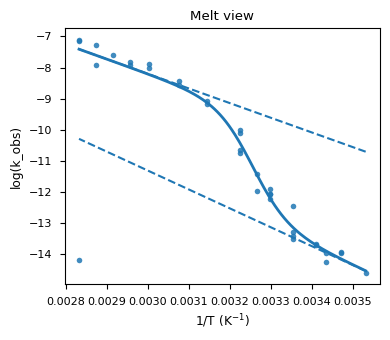

In [31]:
plot_global_melt_2panel(
    res,
    df_filt_A,
    sites_to_plot=[15],   # or None for all
)
plt.show()

In [32]:
# Cell: visualize two-state melt fit(s) pulled from tempgrad results
import json
import math
import sqlite3
from pathlib import Path
from typing import Iterable, Optional, Sequence, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nerd.pipeline.plugins.tempgrad.two_state import melt_fit


def _safe_json_loads(payload: Optional[str]):
    if not payload:
        return None
    return json.loads(payload, parse_constant=lambda v: float("nan"))


def _normalize_site_filter(sites: Optional[Sequence[int] | int]) -> Optional[Set[int]]:
    if sites is None:
        return None
    if isinstance(sites, Iterable) and not isinstance(sites, (str, bytes)):
        site_iter = sites
    else:
        site_iter = [sites]
    normalized: Set[int] = set()
    for item in site_iter:
        try:
            normalized.add(int(item))
        except (TypeError, ValueError):
            continue
    return normalized or None


def _extract_params(row: pd.Series) -> Optional[Tuple[float, float, float, float, float, float]]:
    try:
        a = float(row["a"])
        b = float(row["b"])
        c = float(row["c"])
        d = float(row["d"])
        f = float(row["f"])
        g = float(row["g"])
    except (TypeError, ValueError):
        return None
    if any(math.isnan(val) for val in (a, b, c, d, f, g)):
        return None
    return a, b, c, d, f, g


def visualize_two_state_fit(
    DB_PATH: str | Path,
    RUN_LABEL: str,
    fit_name: str,
    sites: Optional[Sequence[int] | int] = None,
) -> None:
    """
    Plot stored two-state melt fits (and source points) from tempgrad results.

    Parameters
    ----------
    DB_PATH : str | Path
        Path to the NERD SQLite database (e.g., manuscript_pipeline/NERD.sqlite).
    RUN_LABEL : str
        Task run label used in tempgrad execution (e.g., "05_probe_tempgrad_fit").
    fit_name : str
        User-defined `fit_name` captured in the tempgrad configuration.
    sites : optional sequence or int
        One site or many sites (meta_nucleotides.site) to include. Pass None for all.
    """
    db_path = Path(DB_PATH)
    if not db_path.exists():
        raise FileNotFoundError(f"Database not found: {db_path}")

    site_filter = _normalize_site_filter(sites)

    fit_query = """
        SELECT
            fr.id AS fit_run_id,
            fr.target_label,
            fr.created_at,
            n.site AS nt_site,
            MAX(CASE WHEN p.param_name = 'a' THEN p.param_numeric END) AS a,
            MAX(CASE WHEN p.param_name = 'b' THEN p.param_numeric END) AS b,
            MAX(CASE WHEN p.param_name = 'c' THEN p.param_numeric END) AS c,
            MAX(CASE WHEN p.param_name = 'd' THEN p.param_numeric END) AS d,
            MAX(CASE WHEN p.param_name = 'f' THEN p.param_numeric END) AS f,
            MAX(CASE WHEN p.param_name = 'g' THEN p.param_numeric END) AS g,
            MAX(CASE WHEN p.param_name = 'meta:temperatures_used_c' THEN p.param_text END) AS temps_json,
            MAX(CASE WHEN p.param_name = 'meta:src_kobs_data' THEN p.param_text END) AS src_json,
            MAX(CASE WHEN p.param_name = 'request:fit_name' THEN p.param_text END) AS request_fit_name,
            MAX(CASE WHEN p.param_name = 'meta:fit_name' THEN p.param_text END) AS meta_fit_name
        FROM tempgrad_fit_runs fr
        JOIN core_tasks t ON t.id = fr.task_id
        LEFT JOIN meta_nucleotides n ON n.id = fr.nt_id
        JOIN tempgrad_fit_params p ON p.fit_run_id = fr.id
        WHERE t.label = ?
          AND fr.fit_kind = 'two_state_melt'
        GROUP BY fr.id, fr.target_label, fr.created_at, n.site
        HAVING COALESCE(
            MAX(CASE WHEN p.param_name = 'meta:fit_name' THEN p.param_text END),
            MAX(CASE WHEN p.param_name = 'request:fit_name' THEN p.param_text END)
        ) = ?
        ORDER BY fr.created_at DESC;
    """

    with sqlite3.connect(db_path) as conn:
        fit_df = pd.read_sql_query(fit_query, conn, params=(RUN_LABEL, fit_name))

    if fit_df.empty:
        print(f"No two-state melt fits found for run '{RUN_LABEL}' with fit_name '{fit_name}'.")
        return

    if site_filter is not None:
        fit_df = fit_df[fit_df["nt_site"].isin(site_filter)]
        if fit_df.empty:
            sites_str = ", ".join(str(site) for site in sorted(site_filter))
            print(
                f"No two-state melt fits found for run '{RUN_LABEL}' with fit_name '{fit_name}' "
                f"matching site(s): {sites_str}."
            )
            return

    fig, ax_ln = plt.subplots(figsize=(4, 4), constrained_layout=True)
    plotted_any = False

    for _, row in fit_df.iterrows():
        params = _extract_params(row)
        if params is None:
            continue

        try:
            temps_used = _safe_json_loads(row.get("temps_json")) or []
            src_points = _safe_json_loads(row.get("src_json")) or []
        except json.JSONDecodeError:
            continue

        if not src_points:
            continue

        temps_scatter = np.array([pt.get("temperature_c", np.nan) for pt in src_points], dtype=float)
        log_rates = np.array([pt.get("log_kobs2", np.nan) for pt in src_points], dtype=float)
        valid_mask = np.isfinite(temps_scatter) & np.isfinite(log_rates)
        temps_scatter = temps_scatter[valid_mask]
        log_rates = log_rates[valid_mask]
        if temps_scatter.size == 0:
            continue

        order = np.argsort(temps_scatter)
        temps_scatter = temps_scatter[order]
        log_rates = log_rates[order]

        inv_t_points = 1.0 / (temps_scatter + 273.15)
        label_base = row["target_label"]
        site_label = f"site {int(row['nt_site'])}" if pd.notna(row["nt_site"]) else "site ?"
        scatter_label = f"{label_base} ({site_label}) data"

        ax_ln.scatter(inv_t_points, log_rates, alpha=0.7, s=45, label=scatter_label)

        span_min = float(np.nanmin(temps_scatter))
        span_max = float(np.nanmax(temps_scatter))
        if temps_used:
            try:
                temps_used_arr = np.array(temps_used, dtype=float)
                span_min = min(span_min, float(np.nanmin(temps_used_arr)))
                span_max = max(span_max, float(np.nanmax(temps_used_arr)))
            except (TypeError, ValueError):
                pass

        span_c = np.linspace(span_min, span_max, 250)
        inv_span = 1.0 / (span_c + 273.15)
        a, b, c, d, f_val, g_val = params
        rate_pred = melt_fit(inv_span, a, b, c, d, f_val, g_val)
        ax_ln.plot(inv_span, rate_pred, linewidth=2)

        plotted_any = True

    if not plotted_any:
        print(
            f"No plottable two-state melt fits found for run '{RUN_LABEL}' with fit_name '{fit_name}'."
        )
        return

    ax_ln.set_xlabel("1 / Temperature (K$^{-1}$)")
    ax_ln.set_ylabel("ln(kobs2)")
    ax_ln.set_title("Two-State Melt Fits (log domain)")
    ax_ln.grid(True, alpha=0.2)

    handles, labels = ax_ln.get_legend_handles_labels()
    if handles:
        ax_ln.legend(loc="upper right")

    plt.show()

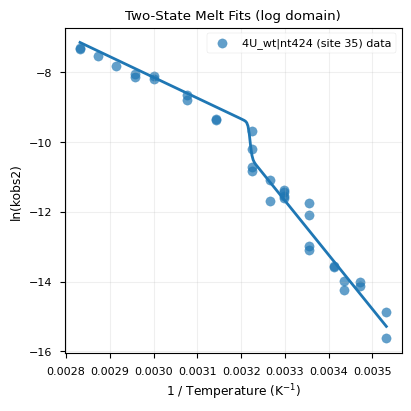

In [46]:

# Example usage (edit and re-run as needed):
visualize_two_state_fit(
    DB_PATH="nerd.sqlite",
    RUN_LABEL="05_probe_tempgrad_fit",
    fit_name="two_state_kobs_global_4U_A",
    sites=[35],  # or a single int / None for all
)